In [89]:
from mpetools import IslandTime, TimeSeriesPreProcess
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import pyproj
import pytz
import datetime
import matplotlib
from pandas.tseries.offsets import MonthEnd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
island_info = IslandTime.retrieve_island_info('Tepuka', 'Tuvalu')


-------------------------------------------------------------------
Retrieving all information available for the island.
Island: Tepuka, Tuvalu
-------------------------------------------------------------------

~ The following information is available: ~

general_info
               island
               country
               part of
               located in or next to body of water
               country_ID
spatial_reference
               latitude
               longitude
               polygon
               polygon_OSM
               reference_shoreline
               transects
image_collection_dict
               description
               S2
               L7
               L8
               L9
timeseries_CRW
               description
               description_timeseries
               source
               timeseries
timeseries_nighttime_light
               description
               description_timeseries
               source
timeseries_disasters
               descrip

# 1. Read monthly-averaged `DataFrame`

In [91]:
df1 = TimeSeriesPreProcess.TimeSeriesPreProcess(island_info, date_range=['2015-01-01', '2020-01-01']).main()


-------------------------------------------------------------------
Time series pre-processing
Retrieving all available time series between 2015-01-01 and 2020-01-01 at a monthly frequency
Island: Tepuka, Tuvalu
-------------------------------------------------------------------



# 2. Retrieve coastline time series

In [76]:
lidx = np.argwhere([np.char.startswith(list(df1.columns)[i], 'coastline_position') for i in range(len(df1.columns))]).flatten()
df_cp = df1[df1.columns[lidx]]

In [7]:
df_cp.plot(marker='.')

<Axes: >

# 3. Retrieve other time series

In [92]:
lidx_o = np.argwhere([~np.char.startswith(list(df1.columns)[i], 'coastline_position') for i in range(len(df1.columns))]).flatten()
df_o = df1[df1.columns[lidx_o]]

# 4. Create `DataFrames` with different frequencies

In [93]:
def get_two_month_period(date):
    month = date.month
    year = date.year

    if month in [1, 2]:
        return datetime.datetime(year=year, month=1, day=30).replace(tzinfo=pytz.UTC)#f"{year}-Jan/Feb"
    elif month in [3, 4]:
        return datetime.datetime(year=year, month=3, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Mar/Apr"
    elif month in [5, 6]:
        return datetime.datetime(year=year, month=5, day=30).replace(tzinfo=pytz.UTC) #f"{year}-May/Jun"
    elif month in [7, 8]:
        return datetime.datetime(year=year, month=7, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Jul/Aug"
    elif month in [9, 10]:
        return datetime.datetime(year=year, month=9, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Sep/Oct"
    else:
        return datetime.datetime(year=year, month=11, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Nov/Dec"

def get_three_month_period(date):
    month = date.month
    year = date.year

    if month in [1, 2, 3]:
        return datetime.datetime(year=year, month=2, day=15).replace(tzinfo=pytz.UTC) #f"{year}-Jan/Feb/Mar"
    elif month in [4, 5, 6]:
        return datetime.datetime(year=year, month=5, day=15).replace(tzinfo=pytz.UTC) #f"{year}-Apr/May/Jun"
    elif month in [7, 8, 9]:
        return datetime.datetime(year=year, month=8, day=15).replace(tzinfo=pytz.UTC) #f"{year}-Jul/Aug/Sep"
    elif month in [10, 11, 12]:
        return datetime.datetime(year=year, month=11, day=15).replace(tzinfo=pytz.UTC) #f"{year}-Oct/Nov/Dec"
    
def get_four_month_period(date):
    month = date.month
    year = date.year

    if month in [1, 2, 3, 4]:
        return datetime.datetime(year=year, month=2, day=28).replace(tzinfo=pytz.UTC) #f"{year}-Jan/Feb/Mar/Apr"
    elif month in [5, 6, 7, 8]:
        return datetime.datetime(year=year, month=6, day=30).replace(tzinfo=pytz.UTC) #f"{year}-May/Jun/Jul/Aug"
    elif month in [9, 10, 11, 12]:
        return datetime.datetime(year=year, month=10, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Sep/Oct/Nov/Dec"

def get_interannual_period(date):
    month = date.month
    year = date.year

    if month in [1, 2, 3, 4, 5, 6]:
        return datetime.datetime(year=year, month=3, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Jan/Feb/Mar/Apr/May/Jun"
    elif month in [7, 8, 9, 10, 11, 12]:
        return datetime.datetime(year=year, month=9, day=30).replace(tzinfo=pytz.UTC) #f"{year}-Jul/Aug/Sep/Oct/Nov/Dec"

# Copies
df_cp_c = df_cp.copy()
df_o_c = df_o.copy()

# Create a new column 'two_month_period' based on the 'date' column
df_cp_c['two_month_period'] = [get_two_month_period(df_cp.index[i]) for i in range(len(df_cp.index))]
df_cp_c['three_month_period'] = [get_three_month_period(df_cp.index[i]) for i in range(len(df_cp.index))]
df_cp_c['four_month_period'] = [get_four_month_period(df_cp.index[i]) for i in range(len(df_cp.index))]
df_cp_c['interannual_period'] = [get_interannual_period(df_cp.index[i]) for i in range(len(df_cp.index))]

# Create a new column 'two_month_period' based on the 'date' column
df_o_c['two_month_period'] = [get_two_month_period(df_o.index[i]) for i in range(len(df_o.index))]
df_o_c['three_month_period'] = [get_three_month_period(df_o.index[i]) for i in range(len(df_o.index))]
df_o_c['four_month_period'] = [get_four_month_period(df_o.index[i]) for i in range(len(df_o.index))]
df_o_c['interannual_period'] = [get_interannual_period(df_o.index[i]) for i in range(len(df_o.index))]

# Group DataFrames (coastline position)
two_month_groups = df_cp_c.groupby('two_month_period', dropna=False).mean()
three_month_groups = df_cp_c.groupby('three_month_period').mean()
four_month_groups = df_cp_c.groupby('four_month_period').mean()
interannual_groups = df_cp_c.groupby('interannual_period').mean()
year_groups = df_cp_c.groupby(pd.Grouper(freq='Y')).mean()

# Group DataFrames (other variables)
two_month_groups_o = df_o_c.groupby('two_month_period', dropna=False).mean()
three_month_groups_o = df_o_c.groupby('three_month_period').mean()
four_month_groups_o = df_o_c.groupby('four_month_period').mean()
interannual_groups_o = df_o_c.groupby('interannual_period').mean()
year_groups_o = df_o_c.groupby(pd.Grouper(freq='Y')).mean()

In [50]:
two_month_groups.plot(marker='.')
three_month_groups.plot(marker='.')
four_month_groups.plot(marker='.')
interannual_groups.plot(marker='.')
year_groups.plot(marker='.')

<Axes: >

In [17]:
two_month_groups_o.plot(marker='.')
three_month_groups_o.plot(marker='.')
four_month_groups_o.plot(marker='.')
interannual_groups_o.plot(marker='.')
year_groups_o.plot(marker='.')

<Axes: >

# 5. Calculate longest consecutive time period

In [94]:
def longest_consecutive_sequence_indices(arr):
    max_length = 0  # Initialize the maximum consecutive sequence length
    current_length = 0  # Initialize the current consecutive sequence length
    max_sequence_indices = []  # Initialize the indices of the longest consecutive sequence
    current_sequence_indices = []  # Initialize the indices of the current consecutive sequence

    for i in range(len(arr)):
        if i > 0 and arr[i] == arr[i - 1] + 1:
            current_length += 1
            current_sequence_indices.append(i)
        else:
            current_length = 1
            current_sequence_indices = [i]

        if current_length > max_length:
            max_length = current_length
            max_sequence_indices = current_sequence_indices.copy()

    return max_sequence_indices

## 6.1 Loop within all transects and frequencies

In [95]:
columns = ['transect', 'frequency', 'start_date', 'end_date', 'number of data points']
frequencies = [df_cp, two_month_groups, three_month_groups, four_month_groups, interannual_groups, year_groups]
frequencies_o = [df_o, two_month_groups_o, three_month_groups_o, four_month_groups_o, interannual_groups_o, year_groups_o]
frequencies_names = ['monthly', 'two_months', 'three_months', 'four_months', 'interannual', 'year']
df_ts = pd.DataFrame(columns=columns)

for idx_freq, freq in enumerate(frequencies):
    df_cpp = freq
    for transect in df_cpp.columns:
        if np.char.startswith(transect, 'coastline_position'):
            arr = df_cpp[transect].values
            idxx = np.argwhere(~pd.isna(arr)).flatten()
            max_sequence_indices = longest_consecutive_sequence_indices(idxx)
            if len(max_sequence_indices) > 0:
                start_date = df_cpp.index[idxx[max_sequence_indices][0]]
                end_date = df_cpp.index[idxx[max_sequence_indices][-1]]
                time_delta = len(idxx[max_sequence_indices])
                df_ts = df_ts.append({'transect': transect, 'frequency': frequencies_names[idx_freq], 'start_date': start_date.replace(tzinfo=pytz.UTC), 'end_date': end_date.replace(tzinfo=pytz.UTC), 'number of data points': time_delta}, ignore_index=True)

In [96]:
for idx_transect, transect in enumerate(df_cp.columns):
    if np.char.startswith(transect, 'coastline_position'):
        number_of_datapoints = []
        number_of_timeseries = []
        for idx_freq, freq in enumerate(frequencies):
            df_ts_o = pd.DataFrame(columns=columns)
            print(frequencies_names[idx_freq])
            row_ts = df_ts[(df_ts.transect == transect) & (df_ts.frequency == frequencies_names[idx_freq])]
            start = datetime.datetime.utcfromtimestamp(row_ts['start_date'].values[0].astype(datetime.datetime)/1e9).replace(tzinfo=pytz.UTC)
            end = datetime.datetime.utcfromtimestamp(row_ts['end_date'].values[0].astype(datetime.datetime)/1e9).replace(tzinfo=pytz.UTC)

            df_o_o = frequencies_o[idx_freq]
            index_date = (df_o_o.index + MonthEnd(0)).to_numpy()
            df_oo = df_o_o[(index_date >= start) & (index_date <= end)]

            for ts in df_oo.columns:
                arr = df_oo[ts].values
                idxx = np.argwhere(~pd.isna(arr)).flatten()
                max_sequence_indices = longest_consecutive_sequence_indices(idxx)
                if len(max_sequence_indices) > 0:
                    start_date = df_oo.index[idxx[max_sequence_indices][0]]
                    end_date = df_oo.index[idxx[max_sequence_indices][-1]]
                    time_delta = len(idxx[max_sequence_indices])
                    if time_delta > 2:
                        df_ts_o = df_ts_o.append({'ts': ts, 'frequency': frequencies_names[idx_freq], 'start_date': start_date, 'end_date': end_date, 'number of data points': time_delta}, ignore_index=True)

            n1 = df_ts_o['number of data points'].max()
            n2 = df_ts_o['number of data points']
            cutoff_df_ts_o = df_ts_o[(abs((n1 - n2) / ((n1 + n2) / 2)) * 100) < 25.]
            int_var = cutoff_df_ts_o.loc[cutoff_df_ts_o['number of data points'] == cutoff_df_ts_o['number of data points'].min()]

            final_start = datetime.datetime.utcfromtimestamp(int_var['start_date'].values[0].astype(datetime.datetime)/1e9).replace(tzinfo=pytz.UTC)
            final_end = datetime.datetime.utcfromtimestamp(int_var['end_date'].values[0].astype(datetime.datetime)/1e9).replace(tzinfo=pytz.UTC)

            df_oo_final = df_o_o[((df_o_o.index + MonthEnd(0)).to_numpy() >= final_start) & ((df_o_o.index + MonthEnd(0)).to_numpy() <= final_end)]
            number_of_datapoints.append(df_oo_final.dropna(axis=1, how='any').shape[0])
            number_of_timeseries.append(df_oo_final.dropna(axis=1, how='any').shape[1])
        plt.figure()
        plt.plot(number_of_timeseries, number_of_datapoints, label='number of data points')
        #plt.plot(frequencies_names, number_of_timeseries, label='number of time series')
        plt.xlabel('number of time series')
        plt.ylabel('number of data points')
        plt.legend()
        plt.title(transect)
        plt.show()

monthly
two_months
three_months
four_months
interannual
year
monthly
two_months
three_months
four_months
interannual
year


KeyboardInterrupt: 

# 6. Number of time series available at that frequency and during that time period

In [130]:
plt.plot(df_cp.index, [df_cp.loc[i].count() for i in df_cp.index])

In [48]:
df1.iloc[np.argmax([df1.loc[i].count() for i in df1.index])]

mean_SST                      29.768871
natural                        0.000000
technological                  0.000000
natural_cumulative             6.000000
technological_cumulative       1.000000
                                ...    
NDVI_coastal_vegetation_L8     0.497726
NDVI_total_vegetation_L9            NaN
NDVI_coastal_vegetation_L9          NaN
NDVI_total_vegetation_S2            NaN
NDVI_coastal_vegetation_S2          NaN
Name: 2016-01-31 00:00:00+00:00, Length: 717, dtype: float64

In [194]:
filee = '2017-12-23-05-37-10_S2_Kondey_Maldives_ms'
pathh = os.path.join(os.getcwd(), 'data', 'coastsat', 'Kondey_Maldives')
#img = tiff.imread(os.path.join(pathh, filee + '.tif'))
path_file = os.path.join(pathh, filee + '.tif')

<Axes: xlabel='datetime'>

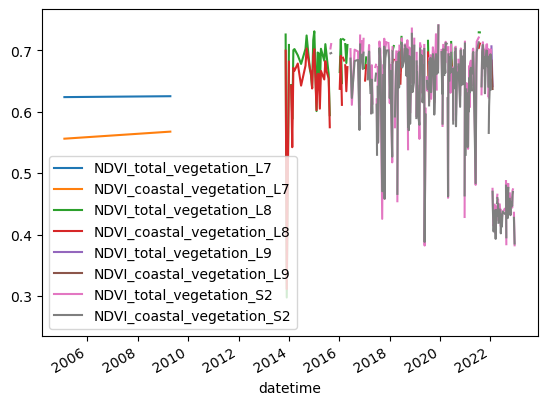

In [5]:
island_info['timeseries_vegetation']['timeseries'].plot()

In [46]:
import matplotlib
%matplotlib qt

L9 = island_info['timeseries_vegetation']['timeseries_L9']
L8 = island_info['timeseries_vegetation']['timeseries_L8']
L7 = island_info['timeseries_vegetation']['timeseries_L7']
S2 = island_info['timeseries_vegetation']['timeseries_S2']

L9

,NDVI_total_vegetation,NDVI_coastal_vegetation,NDVI_transect_0,NDVI_transect_1,NDVI_transect_2,NDVI_transect_3,NDVI_transect_4,NDVI_transect_5,NDVI_transect_6,NDVI_transect_7,...,NDVI_transect_41,NDVI_transect_42,NDVI_transect_43,NDVI_transect_44,NDVI_transect_45,NDVI_transect_46,NDVI_transect_47,NDVI_transect_48,NDVI_transect_49,NDVI_transect_50
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-15,0.706769,0.683562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31,0.642116,0.634004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-31,0.641535,0.640609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-04,0.628092,0.636283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05,0.648810,0.633904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-05,0.648441,0.633275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-21,0.681831,0.657577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-21,0.682221,0.656988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-07,0.615058,0.592817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
plt.imshow(island_info['timeseries_vegetation']['mask_transects_vegetation_S2'][1])


In [27]:
transects = island_info['spatial_reference']['transects']
reference_shoreline = island_info['spatial_reference']['reference_shoreline']

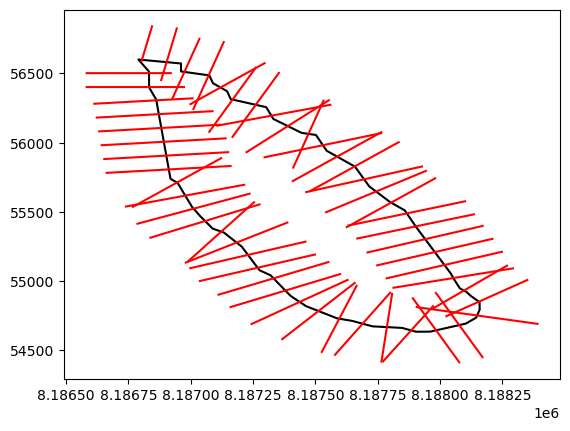

In [30]:
plt.plot(reference_shoreline[:,0], reference_shoreline[:,1], 'k')
for trans in transects.keys():
    plt.plot(transects[trans][:, 0], transects[trans][:, 1], 'r')

In [142]:
from osgeo import gdal
data = gdal.Open(os.path.join(pathh, filee + '.tif'), gdal.GA_ReadOnly)
np.array(data.GetGeoTransform())
data

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002024991ED90> >

In [280]:
# Extract geotransform parameters
x_origin = geotransform[0]
y_origin = geotransform[3]
pixel_width = geotransform[1]
pixel_height = geotransform[5]

# Get the dimensions of the raster
width = data.RasterXSize
height = data.RasterYSize

# Create a mesh grid of coordinates
x = np.arange(x_origin, x_origin + (width * pixel_width), pixel_width)
y = np.arange(y_origin, y_origin + (height * pixel_height), pixel_height)

# Define the source and target coordinate systems
src_crs = pyproj.CRS('EPSG:32643')
tgt_crs = pyproj.CRS('EPSG:3857')

# Create a transformer
transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)

# Use numpy.meshgrid to create the mesh grid
xx, yy = np.meshgrid(x, y)

In [120]:
points = reference_shoreline

In [283]:

# define transformer
proj = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:32643'), always_xy=True)

# transform points
if type(points) is list:
    points_converted = []
    # iterate over the list
    for i, arr in enumerate(points): 
        x,y = proj.transform(arr[:,0], arr[:,1])
        arr_converted = np.transpose(np.array([x,y]))
        points_converted.append(arr_converted)
elif type(points) is np.ndarray:
    x,y = proj.transform(points[:,0], points[:,1])
    points_converted = np.transpose(np.array([x,y]))
else:
    raise Exception('invalid input type')

In [285]:
points_converted

array([[338993.29682198,  55019.30198746],
       [338993.15365896,  55019.68326686],
       [338993.01049595,  55020.06454626],
       ...,
       [338994.24998251,  55017.0142904 ],
       [338993.77340224,  55018.15813893],
       [338993.29682198,  55019.30198746]])

In [284]:
np.column_stack((x,y))

array([[338993.29682198,  55019.30198746],
       [338993.15365896,  55019.68326686],
       [338993.01049595,  55020.06454626],
       ...,
       [338994.24998251,  55017.0142904 ],
       [338993.77340224,  55018.15813893],
       [338993.29682198,  55019.30198746]])

In [124]:
points_converted

array([[338993.29682198,  55019.30198746],
       [338993.15365896,  55019.68326686],
       [338993.01049595,  55020.06454626],
       ...,
       [338994.24998251,  55017.0142904 ],
       [338993.77340224,  55018.15813893],
       [338993.29682198,  55019.30198746]])

In [277]:
os.listdir(pathh)

['jpg_files',
 'Kondey_Maldives_metadata.pkl',
 'Kondey_Maldives_output.pkl',
 'L5',
 'L7',
 'L8',
 'L9',
 'S2',
 'transect_time_series.csv']

In [72]:
data = gdal.Open(os.path.join(pathh, filee + '.tif'), gdal.GA_ReadOnly)
georef = np.array(data.GetGeoTransform())
bands = [data.GetRasterBand(k + 1).ReadAsArray() for k in range(data.RasterCount)]
im_ms = np.stack(bands, 2)

In [144]:
np.shape(im_ms)

(222, 168, 5)

In [ ]:
# make sure that the pixel coordinates of the reference shoreline are inside the image
idx_row = np.logical_and(ref_sl_pix_rounded[:,0] > 0, ref_sl_pix_rounded[:,0] < im_shape[1])
idx_col = np.logical_and(ref_sl_pix_rounded[:,1] > 0, ref_sl_pix_rounded[:,1] < im_shape[0])
idx_inside = np.logical_and(idx_row, idx_col)
ref_sl_pix_rounded = ref_sl_pix_rounded[idx_inside,:]

In [47]:
from tqdm import tqdm
import shapely

In [77]:
img = im_ms[:, :, 0]

100%|██████████| 222/222 [00:30<00:00,  7.27it/s]


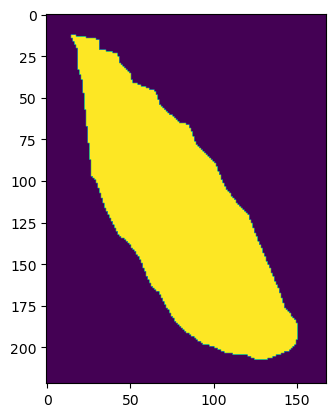

In [127]:
# Create shapely.geometry.Polygon and shapely.geometry.LineString objects
polygon_reference_shoreline = shapely.geometry.Polygon(points_converted)
linestring_reference_shoreline = shapely.geometry.LineString(points_converted)

# Create an empty mask array with the same shape as the meshgrid
mask_total_vegetation, mask_coastal_vegetation = np.zeros(xx.shape, dtype=bool), np.zeros(xx.shape, dtype=bool)

# Create dictionary for transect masks
mask_transects_vegetation = {}
for transect in transects.keys():
    mask_transects_vegetation[transect] = np.zeros(xx.shape, dtype=bool)

# Fill masks
for i in tqdm(range(xx.shape[0])):
    for j in range(xx.shape[1]):
        point = shapely.geometry.Point(xx[i, j], yy[i, j])

        # Total vegetation
        if polygon_reference_shoreline.contains(point):
            mask_total_vegetation[i, j] = True
                        
        # Coastal vegetation
        if polygon_reference_shoreline.contains(point) and point.distance(linestring_reference_shoreline) < 100:
            mask_coastal_vegetation[i, j] = True

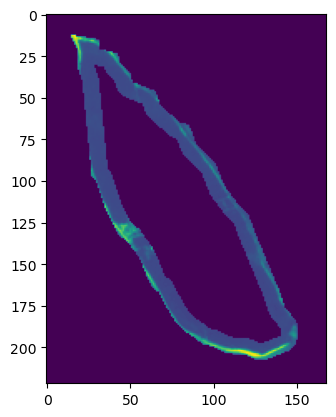

In [133]:
#plt.imshow(img)
plt.imshow(np.multiply(mask_coastal_vegetation, img))

In [162]:
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [156]:
masked = np.multiply(im_ms, mask_total_vegetation[:, :, np.newaxis])
masked

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]

In [263]:
import pickle
metadata = pickle.load(open(os.path.join(os.getcwd(), 'data', 'coastsat', 'Kondey_Maldives', 'Kondey_Maldives_metadata.pkl'), 'rb'))

In [275]:
epsg_list = np.unique(np.array(metadata['S2']['epsg']), return_counts=True)
epsg_image = epsg_list[0][np.argmax(epsg_list[1])]

In [276]:
epsg_image

32643

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 0.        ,  6.78994819, 13.57989637, 20.36984456, 27.15979275,
        33.94974093, 40.73968912, 47.52963731, 54.31958549, 61.10953368,
        67.89948187]),
 <a list of 168 BarContainer objects>)

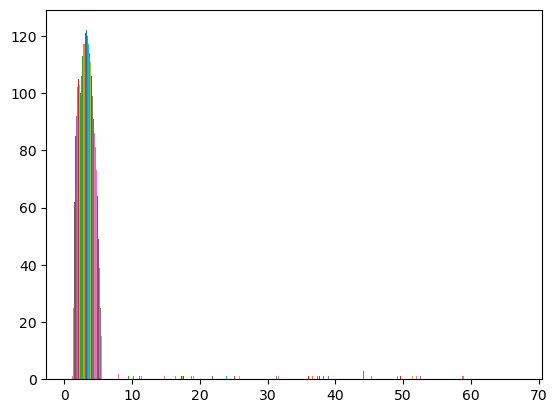

In [158]:
plt.hist(ndvi)

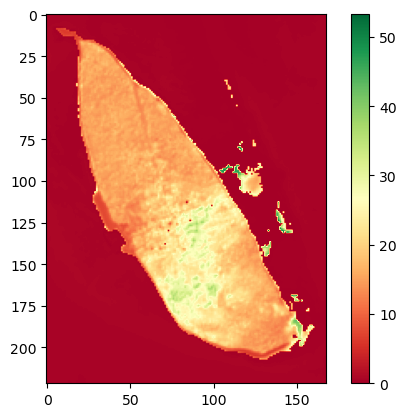

In [180]:
# 'B2','B3','B4','B8','s2cloudless','B11',qa_band_S2
# Blue Green Red NIR SWIR 1
# NDVI = (NIR - Red) / (NIR + Red)
ndvi = (im_ms[:, :, 1] - im_ms[:, :, 3]) / (im_ms[:, :, 1] +im_ms[:, :, 3])
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()

In [ ]:
red = im_ms[:, : 2]
green = im_ms[:, :, 4]

In [187]:
from coastsatmaster.coastsat import SDS_preprocess, SDS_download, SDS_shoreline, SDS_tools

In [200]:
settings = island_info['timeseries_coastsat']['settings']

In [204]:
collection = 'C02'

In [248]:
metadata[satname]

{'filenames': ['2015-08-16-05-37-06_S2_Kondey_Maldives_ms.tif',
  '2015-08-16-05-37-06_S2_Kondey_Maldives_ms_dup1.tif',
  '2015-08-16-05-37-06_S2_Kondey_Maldives_ms_dup2.tif',
  '2015-08-26-05-37-05_S2_Kondey_Maldives_ms.tif',
  '2015-08-26-05-37-05_S2_Kondey_Maldives_ms_dup1.tif',
  '2015-08-26-05-37-05_S2_Kondey_Maldives_ms_dup2.tif',
  '2015-09-05-05-37-07_S2_Kondey_Maldives_ms.tif',
  '2015-09-05-05-37-07_S2_Kondey_Maldives_ms_dup1.tif',
  '2015-10-05-05-37-08_S2_Kondey_Maldives_ms.tif',
  '2015-10-05-05-37-08_S2_Kondey_Maldives_ms_dup1.tif',
  '2015-11-24-05-35-32_S2_Kondey_Maldives_ms.tif',
  '2015-12-04-05-37-06_S2_Kondey_Maldives_ms.tif',
  '2015-12-04-05-37-06_S2_Kondey_Maldives_ms_dup1.tif',
  '2015-12-04-05-39-16_S2_Kondey_Maldives_ms.tif',
  '2015-12-24-05-39-17_S2_Kondey_Maldives_ms.tif',
  '2015-12-24-05-39-17_S2_Kondey_Maldives_ms_dup1.tif',
  '2016-01-03-05-39-16_S2_Kondey_Maldives_ms.tif',
  '2016-01-03-05-39-16_S2_Kondey_Maldives_ms_dup1.tif',
  '2016-01-23-05-39-10_S

In [262]:
# loop through satellites
for satname in ['S2']:
    filepath = SDS_tools.get_filepath(settings['inputs'],satname)
    filenames = metadata[satname]['filenames']
    # loop through images
    for i in range(len(filenames)):
        fn = SDS_tools.get_filenames(filenames[i],filepath, satname)
        #print()
        im_ms, georef, cloud_mask, im_extra, im_QA, im_nodata = SDS_preprocess.preprocess_single(fn, satname, 
                                                                                                    settings['cloud_mask_issue'],
                                                                                                    settings['pan_off'],
                                                                                                    collection)

        # compute cloud_cover percentage (with no data pixels)
        cloud_cover_combined = np.divide(sum(sum(cloud_mask.astype(int))),
                                (cloud_mask.shape[0]*cloud_mask.shape[1]))
        if cloud_cover_combined > 0.99: # if 99% of cloudy pixels in image skip
            continue

        # remove no data pixels from the cloud mask (for example L7 bands of no data should not be accounted for)
        cloud_mask_adv = np.logical_xor(cloud_mask, im_nodata)
        # compute updated cloud cover percentage (without no data pixels)
        cloud_cover = np.divide(sum(sum(cloud_mask_adv.astype(int))),
                                (sum(sum((~im_nodata).astype(int)))))
        # skip image if cloud cover is above threshold
        if cloud_cover > settings['cloud_thresh'] or cloud_cover == 1:
            continue
        # get individual RGB image
        im_RGB = SDS_preprocess.rescale_image_intensity(im_ms[:,:,[2,1,0]], cloud_mask, 99.9)
        im_NDVI = SDS_tools.nd_index(im_ms[:,:,3], im_ms[:,:,2], cloud_mask)
        im_NDWI = SDS_tools.nd_index(im_ms[:,:,3], im_ms[:,:,1], cloud_mask)

        try:
            mask_ndvi = np.multiply(im_NDVI, mask_coastal_vegetation)
            print(np.mean(mask_ndvi[(mask_ndvi > 0.3) & (mask_ndvi < 0.9)]))
            print(fn[0].split('\\')[-1].split('_')[0].split('-')[:3])
        except:
            continue

0
1
2
3
0.703657328025918
['2015', '08', '26']
4
0.7023231062366191
['2015', '08', '26']
5
0.7023231062366191
['2015', '08', '26']
6
0.7026117543083492
['2015', '09', '05']
7
0.7026117543083492
['2015', '09', '05']
8
0.7181298536093015
['2015', '10', '05']
9
0.7181298536093015
['2015', '10', '05']
10
nan
['2015', '11', '24']
11
0.6718499495537881
['2015', '12', '04']
12
0.6718499495537881
['2015', '12', '04']
13
0.6674189471326233
['2015', '12', '04']
14
15
16
0.6842870610108428
['2016', '01', '03']
17
0.6842870610108428
['2016', '01', '03']
18
0.7118741942362941
['2016', '01', '23']
19
0.7118741942362941
['2016', '01', '23']
20
21
22
0.6593734100373514
['2016', '02', '12']
23
0.6593734100373514
['2016', '02', '12']
24
0.705395228570946
['2016', '03', '23']
25
0.705395228570946
['2016', '03', '23']
26
0.6635457080770324
['2016', '04', '12']
27
0.6635457080770324
['2016', '04', '12']
28
29
30
0.6518497274130433
['2016', '05', '02']
31
0.6530733148831481
['2016', '05', '02']
32
33
34
0.6

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.36353712, -0.26984927, -0.17616142, -0.08247358,  0.01121427,
         0.10490212,  0.19858997,  0.29227781,  0.38596566,  0.47965351,
         0.57334136]),
 <a list of 168 BarContainer objects>)

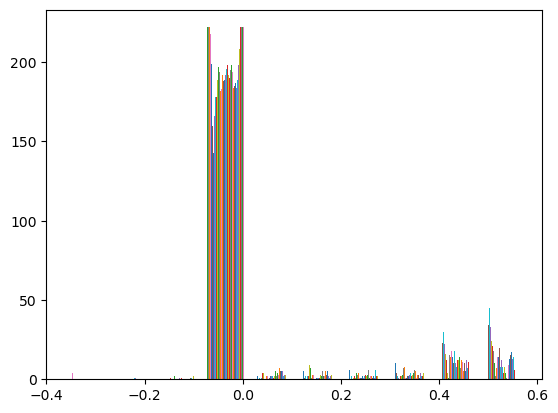

In [218]:
plt.hist(np.multiply(im_NDVI, mask_coastal_vegetation))

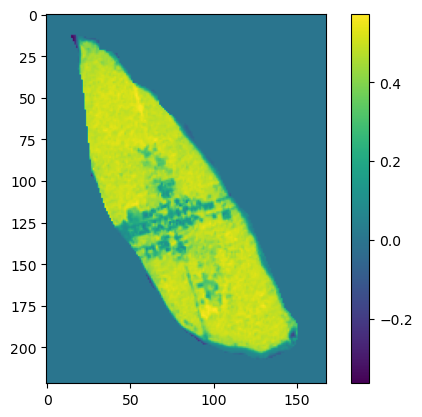

In [227]:
plt.imshow(np.multiply(im_NDVI, mask_total_vegetation))
plt.colorbar()

0.04821504457677752